In [2]:
pip install import-ipynb



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#from pandas.io.formats.format import DataFrameRenderer
import import_ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_squared_error

In [5]:
# Get user input for the ticker symbol
ticker = input("Enter the ticker symbol of the company you want to predict: ")

# Read in the historical stock price data for the company from Yahoo Finance
data = pd.read_csv(f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=1535981100&period2=1620605100&interval=1d&events=history&includeAdjustedClose=true')

Enter the ticker symbol of the company you want to predict: AAPL


In [6]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Open'] = scaler.fit_transform(np.array(data['Open']).reshape(-1, 1))
data['Scaled_Close'] = scaler.fit_transform(np.array(data['Close']).reshape(-1, 1))
data['Scaled_High'] = scaler.fit_transform(np.array(data['High']).reshape(-1, 1))
data['Scaled_Low'] = scaler.fit_transform(np.array(data['Low']).reshape(-1, 1))

# Define the input and output data
X = np.array(data[['Scaled_Open', 'Scaled_Close', 'Scaled_High', 'Scaled_Low']])
y = np.array(data['Scaled_Close'])

In [7]:
# Define the train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [8]:
# Define the model architecture
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [9]:
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Scaled_Open,Scaled_Close,Scaled_High,Scaled_Low
0,2018-09-04,57.102501,57.294998,56.657501,57.090000,54.605076,109560400,0.196157,0.200186,0.192021,0.199844
1,2018-09-05,57.247501,57.417500,56.275002,56.717499,54.248787,133332000,0.197505,0.196724,0.193148,0.196231
2,2018-09-06,56.557499,56.837502,55.325001,55.775002,53.347305,137160000,0.191092,0.187966,0.187811,0.187258
3,2018-09-07,55.462502,56.342499,55.177502,55.325001,52.916897,150479200,0.180916,0.183784,0.183255,0.185865
4,2018-09-10,55.237499,55.462502,54.117500,54.582500,52.206722,158066000,0.178825,0.176885,0.175156,0.175852


In [10]:
# Train the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
9/9 - 9s - loss: 0.1008 - val_loss: 0.4784 - 9s/epoch - 979ms/step
Epoch 2/50
9/9 - 0s - loss: 0.0565 - val_loss: 0.2495 - 160ms/epoch - 18ms/step
Epoch 3/50
9/9 - 0s - loss: 0.0204 - val_loss: 0.0547 - 136ms/epoch - 15ms/step
Epoch 4/50
9/9 - 0s - loss: 0.0100 - val_loss: 0.0029 - 148ms/epoch - 16ms/step
Epoch 5/50
9/9 - 0s - loss: 0.0091 - val_loss: 0.0118 - 155ms/epoch - 17ms/step
Epoch 6/50
9/9 - 0s - loss: 0.0050 - val_loss: 0.0222 - 158ms/epoch - 18ms/step
Epoch 7/50
9/9 - 0s - loss: 0.0036 - val_loss: 0.0095 - 134ms/epoch - 15ms/step
Epoch 8/50
9/9 - 0s - loss: 0.0019 - val_loss: 9.5221e-04 - 141ms/epoch - 16ms/step
Epoch 9/50
9/9 - 0s - loss: 0.0012 - val_loss: 1.1517e-04 - 137ms/epoch - 15ms/step
Epoch 10/50
9/9 - 0s - loss: 6.1714e-04 - val_loss: 1.6107e-04 - 134ms/epoch - 15ms/step
Epoch 11/50
9/9 - 0s - loss: 3.9155e-04 - val_loss: 3.2299e-04 - 124ms/epoch - 14ms/step
Epoch 12/50
9/9 - 0s - loss: 2.8881e-04 - val_loss: 9.4647e-04 - 144ms/epoch - 16ms/step
Epoch 1

In [11]:
# Evaluate the model
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Train RMSE:', np.sqrt(train_score))
print('Test RMSE:', np.sqrt(test_score))

Train RMSE: 0.008222500980558056
Test RMSE: 0.012018816850113233


In [12]:
# Make predictions on the test set
y_pred = model.predict(X_test)


5/5 [==============================] - 1s 5ms/step


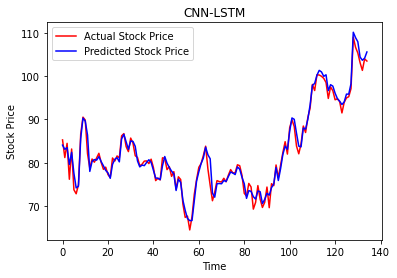

In [29]:
# Plot the actual and predicted stock prices
scale_factor = 0.00917562
y_pred = y_pred / scale_factor
y_test = y_test / scale_factor
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 33345 (130.25 KB)
Trainable params: 33345 (130.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.save('cnn_lstm.h5')

C:\Users\Prerna\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
scaler.scale_

array([0.00944555])

In [16]:
# Make predictions on the test set
X_pred = np.array([X_test[-1]])
X_pred = X_pred.reshape((X_pred.shape[0], X_pred.shape[1], 1))
y_pred = model.predict(X_pred)

# Inverse transform the scaled prediction
y_pred = scaler.inverse_transform(y_pred)

print('Tomorrow\'s predicted closing price:', y_pred[0])

1/1 [==============================] - 0s 47ms/step
Tomorrow's predicted closing price: [129.56744]


In [17]:
# Get the regression equation
regression_coef = model.layers[-1].get_weights()[0][0]
regression_intercept = model.layers[-1].get_weights()[1][0]
print('Regression Equation: y =', regression_coef, '* x +', regression_intercept)

Regression Equation: y = [-0.29558566] * x + 0.009034116
